In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Verzeichnis der CSV-Dateien
ids17_prep_0 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_0'
ids18_prep_0 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_0'
hybrid_prep_0 = '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_0'

## Datensätze laden

In [3]:
df_ids17 = pd.read_parquet(ids17_prep_0)
df_ids18 = pd.read_parquet(ids18_prep_0)
df_hybrid = pd.read_parquet(hybrid_prep_0)

## Klassenübersichten anzeigen

In [4]:
# Entferne nicht verwendete Kategorien aus der 'Label'-Spalte in ids18
df_ids18['Label'] = df_ids18['Label'].cat.remove_unused_categories()

In [5]:
df_ids18['Label'].value_counts()

Label
BENIGN                          2967676
DoS Hulk                        1803160
DDoS-LOIC-HTTP                   289328
Botnet Ares                      142921
SSH-BruteForce                    94197
Infiltration - NMAP Portscan      89374
DoS GoldenEye                     22560
DoS Slowloris                      8490
Name: count, dtype: int64

In [6]:
df_ids17['Label'].value_counts()


Label
BENIGN                          1582561
DoS Hulk                         158468
DDoS-LOIC-HTTP                    95144
Infiltration - NMAP Portscan      71767
DoS GoldenEye                      7567
DoS Slowloris                      3859
SSH-BruteForce                     2961
Botnet Ares                         736
Name: count, dtype: int64

In [7]:
df_hybrid['Label'].value_counts()


Label
DoS Hulk                        1961628
BENIGN                          1582561
DDoS-LOIC-HTTP                   384472
Infiltration - NMAP Portscan     161141
Botnet Ares                      143657
SSH-BruteForce                    97158
DoS GoldenEye                     30127
DoS Slowloris                     12349
Name: count, dtype: int64

## Feature Selection

### Datensatz wählen

In [ ]:
# Lade den Datensatz
data = df_ids18

# Features und Zielvariable trennen
X = data.drop('Label', axis=1)
y = data['Label']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

# Aufteilen in Trainings- und temporäre Datensätze damit die Feature Selection nur auf Trainingsdaten durchgeführt wird
# Split wird genauso wie später im Training durchgeführt - random_state_42 und stratify
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.20, random_state=42, stratify=y)

# Aufteilen in Validierungs- und Testdaten
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Form von X_train:", X_train.shape)
print("Form von X_val:", X_val.shape)
print("Form von X_test:", X_test.shape)

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce']
Kodierte Labels: [0 1 2 3 4 5 6 7]
Form von X_train: (4334164, 81)
Form von X_val: (541771, 81)
Form von X_test: (541771, 81)


### Korrelationsmatrix

In [9]:
# Korrelationsmatrix berechnen
correlation_matrix = X_train.corr()

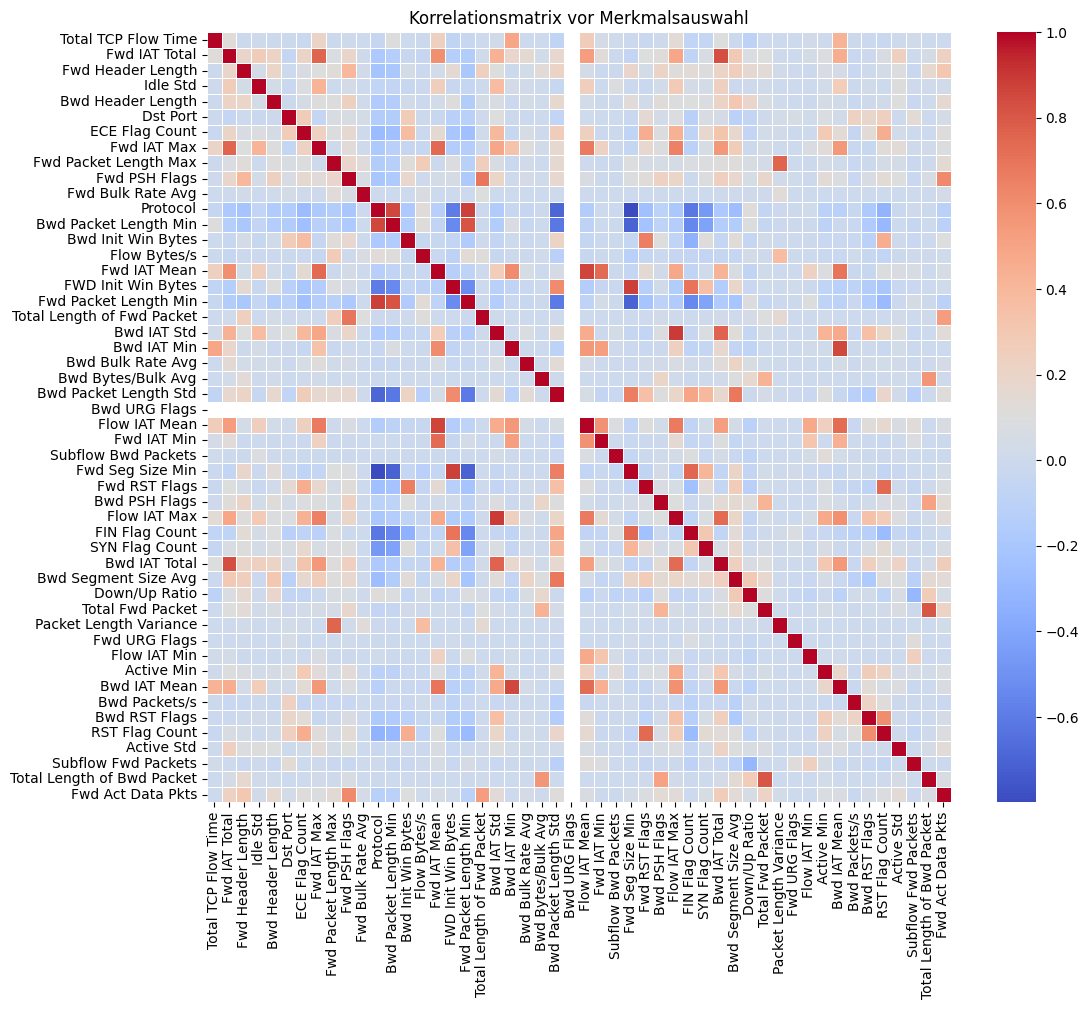

In [27]:
# Größe der Grafik 
plt.figure(figsize=(12, 10))

# Heatmap erstellen
sns.heatmap(correlation_matrix, 
            cmap="coolwarm",   # Farbschema der Heatmap
            linewidths=0.5)    # Linien zwischen den Zellen

# Titel hinzufügen
plt.title("Korrelationsmatrix vor Merkmalsauswahl")

# Grafik anzeigen
plt.show()

In [12]:
# Finde stark korrelierte Paare
threshold = 0.9
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            high_corr_pairs.append(pair)
print(f'{len(high_corr_pairs)} stark korrelierte Paare gefunden.')

# Liste der Paare anzeigen
print("Stark korrelierte Paare:")
for pair in high_corr_pairs:
    print(f"{pair}")


52 stark korrelierte Paare gefunden.
Stark korrelierte Paare:
('Total Length of Bwd Packet', 'Total Bwd packets')
('Fwd Packet Length Std', 'Fwd Packet Length Max')
('Fwd Packet Length Std', 'Fwd Packet Length Mean')
('Bwd Packet Length Std', 'Bwd Packet Length Max')
('Flow IAT Max', 'Flow IAT Std')
('Fwd IAT Max', 'Fwd IAT Std')
('Bwd IAT Total', 'Flow Duration')
('Bwd IAT Max', 'Flow IAT Max')
('Bwd IAT Max', 'Bwd IAT Std')
('Fwd Packets/s', 'Flow Packets/s')
('Bwd Packets/s', 'Flow Packets/s')
('Bwd Packets/s', 'Fwd Packets/s')
('Packet Length Min', 'Fwd Packet Length Min')
('Packet Length Max', 'Fwd Packet Length Max')
('Packet Length Max', 'Fwd Packet Length Std')
('Packet Length Std', 'Fwd Packet Length Std')
('Packet Length Std', 'Packet Length Max')
('Packet Length Std', 'Packet Length Mean')
('Packet Length Variance', 'Fwd Packet Length Mean')
('PSH Flag Count', 'Bwd PSH Flags')
('ACK Flag Count', 'Total Bwd packets')
('ACK Flag Count', 'Total Length of Bwd Packet')
('URG Flag

### Random Forest Classifier

In [17]:
# Random Forest trainieren
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [18]:
joblib.dump(rf, 'rf_model.pkl')

['rf_model.pkl']

In [19]:
# Feature Importances extrahieren
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Wichtigste Features ausgeben
print(feature_importance_df.head(30))

                       feature  importance
68          FWD Init Win Bytes    0.100098
71            Fwd Seg Size Min    0.093841
46              FIN Flag Count    0.051519
14       Bwd Packet Length Std    0.039346
69          Bwd Init Win Bytes    0.035724
11       Bwd Packet Length Max    0.032797
57        Bwd Segment Size Avg    0.031587
0                     Dst Port    0.029177
13      Bwd Packet Length Mean    0.028733
7        Fwd Packet Length Max    0.028175
6   Total Length of Bwd Packet    0.026976
42           Packet Length Max    0.026910
10       Fwd Packet Length Std    0.025298
38           Bwd Header Length    0.024282
25                 Fwd IAT Min    0.022529
50              ACK Flag Count    0.020814
4            Total Bwd packets    0.020588
44           Packet Length Std    0.020474
20                Flow IAT Min    0.019640
5   Total Length of Fwd Packet    0.019483
45      Packet Length Variance    0.017942
67           Subflow Bwd Bytes    0.016480
32         

/tmp/ipykernel_984493/3011738313.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


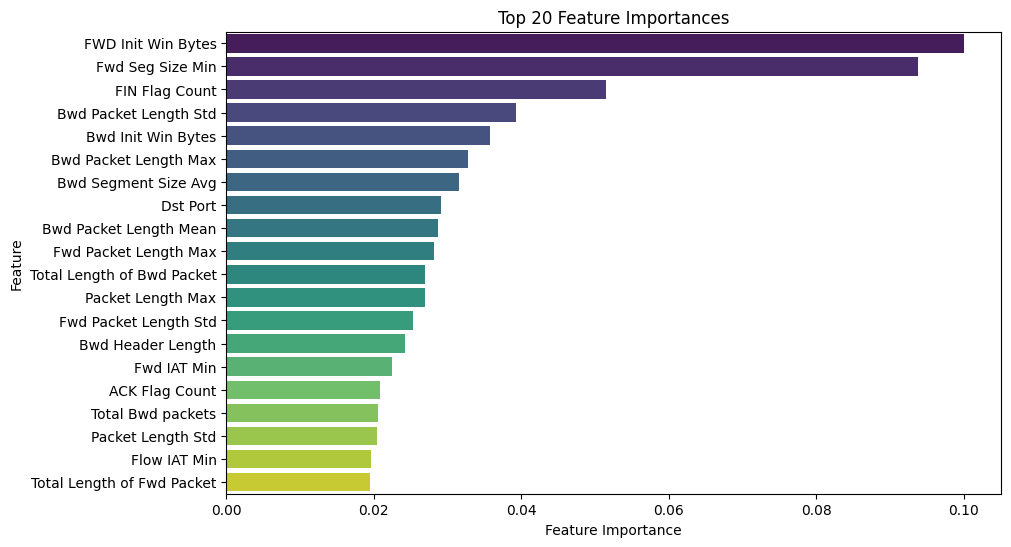

In [ ]:
top_n = 20  # Anzahl der Features, die du plotten möchtest
top_features = feature_importance_df.head(top_n)

# Plot erstellen
plt.figure(figsize=(10, 6))
sns.barplot(
    x='importance',
    y='feature',
    data=top_features,
    palette='viridis'
)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances')
plt.show()

In [ ]:
# Behalte von stark korrelierten Paaren das wichtigere Feature
features_to_keep = set(X.columns)  # Alle Features
for feature1, feature2 in high_corr_pairs:
    importance1 = feature_importance_df.loc[feature_importance_df['feature'] == feature1, 'importance'].values[0]
    importance2 = feature_importance_df.loc[feature_importance_df['feature'] == feature2, 'importance'].values[0]
    print(f"Feature1: {feature1}, Importance: {importance1}" + " vs. " + f"Feature2: {feature2}, Importance: {importance2}")
    # Entferne das Feature mit der geringeren Importance
    if importance1 > importance2:
        features_to_keep.discard(feature2)
        print(f"Entferntes Feature: {feature2}")
    else:
        features_to_keep.discard(feature1)
        print(f"Entferntes Feature: {feature1}")

# Finaler reduzierter Datensatz
X_final = X[list(features_to_keep)]
print(f"Behaltene Features: {features_to_keep}")

Feature1: Total Length of Bwd Packet, Importance: 0.026975839728002417 vs. Feature2: Total Bwd packets, Importance: 0.02058800939515338
Entferntes Feature: Total Bwd packets
Feature1: Fwd Packet Length Std, Importance: 0.025297519515373037 vs. Feature2: Fwd Packet Length Max, Importance: 0.028174658827167427
Entferntes Feature: Fwd Packet Length Std
Feature1: Fwd Packet Length Std, Importance: 0.025297519515373037 vs. Feature2: Fwd Packet Length Mean, Importance: 0.01292380442140635
Entferntes Feature: Fwd Packet Length Mean
Feature1: Bwd Packet Length Std, Importance: 0.039346043366572186 vs. Feature2: Bwd Packet Length Max, Importance: 0.0327966664989509
Entferntes Feature: Bwd Packet Length Max
Feature1: Flow IAT Max, Importance: 0.005963060706010933 vs. Feature2: Flow IAT Std, Importance: 0.0034310391297727814
Entferntes Feature: Flow IAT Std
Feature1: Fwd IAT Max, Importance: 0.006189397278131721 vs. Feature2: Fwd IAT Std, Importance: 0.00329784185221623
Entferntes Feature: Fwd IA

In [21]:
# Finaler reduzierter Datensatz
X_final = X[list(features_to_keep)]

print(f"Behaltene Features: {features_to_keep}")

Behaltene Features: {'Total TCP Flow Time', 'Fwd IAT Total', 'Fwd Header Length', 'Idle Std', 'Bwd Header Length', 'Dst Port', 'ECE Flag Count', 'Fwd IAT Max', 'Fwd Packet Length Max', 'Fwd PSH Flags', 'Fwd Bulk Rate Avg', 'Protocol', 'Bwd Packet Length Min', 'Bwd Init Win Bytes', 'Flow Bytes/s', 'Fwd IAT Mean', 'FWD Init Win Bytes', 'Fwd Packet Length Min', 'Total Length of Fwd Packet', 'Bwd IAT Std', 'Bwd IAT Min', 'Bwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Packet Length Std', 'Bwd URG Flags', 'Flow IAT Mean', 'Fwd IAT Min', 'Subflow Bwd Packets', 'Fwd Seg Size Min', 'Fwd RST Flags', 'Bwd PSH Flags', 'Flow IAT Max', 'FIN Flag Count', 'SYN Flag Count', 'Bwd IAT Total', 'Bwd Segment Size Avg', 'Down/Up Ratio', 'Total Fwd Packet', 'Packet Length Variance', 'Fwd URG Flags', 'Flow IAT Min', 'Active Min', 'Bwd IAT Mean', 'Bwd Packets/s', 'Bwd RST Flags', 'RST Flag Count', 'Active Std', 'Subflow Fwd Packets', 'Total Length of Bwd Packet', 'Fwd Act Data Pkts'}


In [22]:
X_final.shape

(5417706, 50)

### Korellationsmatrix nach Feature Selection

In [23]:
# Korrelationsmatrix berechnen
correlation_matrix = X_final.corr()

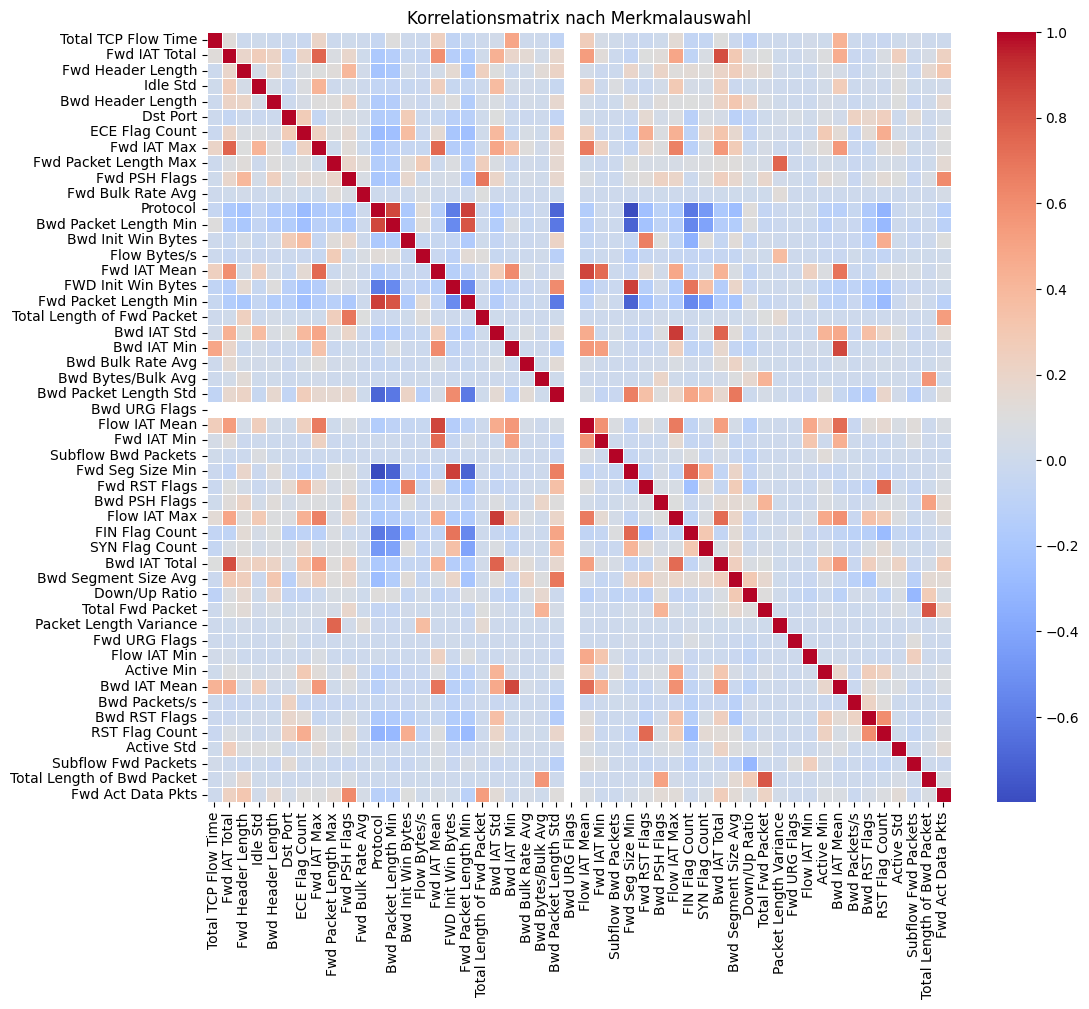

In [28]:
# Größe der Grafik 
plt.figure(figsize=(12, 10))

# Heatmap erstellen
sns.heatmap(correlation_matrix, 
            annot=False,        # Korrelationskoeffizienten anzeigen
            fmt=".2f",         # Format der Koeffizienten
            cmap="coolwarm",   # Farbschema der Heatmap
            linewidths=0.5)    # Linien zwischen den Zellen

# Titel hinzufügen (optional)
plt.title("Korrelationsmatrix nach Merkmalauswahl")

# Grafik anzeigen
plt.show()

In [25]:
# Speichern der reduzierten Features
with open('22_reduced_features.txt', 'w') as f:
    for item in features_to_keep:
        f.write("%s\n" % item)